In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin

# Import data

In [2]:
# file path to data folder
path = './Output'

In [3]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)
subjects = np.unique(data['subjectID'])

# Leave-one-subject-out CV folds

In [5]:
N = data.shape[0]
X = data[['subjectID', 'phF', 'MF', 'VAS']]

def LOSOCV_splitter(X):
    folds = [] # [(train=indices(-subject), test=indices(subject)), ...]

    # folds -> subjects
    for subject in subjects:
        train_indices = np.arange(N)[data['subjectID'] != subject]
        test_indices = np.arange(N)[data['subjectID'] == subject]

        folds.append((train_indices, test_indices))

    return folds

# Model

In [6]:
class MajorityVoter(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):
        return self

    def predict(self, X: np.ndarray):
        """Prediction for multiple batches"""
        n_to_predict = [N - np.count_nonzero(~np.isnan(X[batch])) for batch in range(X.shape[0])]

        # majority vote
        majority_vote = np.round(np.nanmean(X, axis=1))
        y_pred = np.array([[majority_vote[batch] for _ in range(n)] for batch, n in enumerate(n_to_predict)]).reshape(-1)

        return y_pred

# Model evaluation

phF:

accuracy: 0.6656024430564949, balanced accuracy: 0.5555555555555556, f1: 0.7578259815689583, recall: 0.9629629629629629, precision: 0.6656024430564949

MF:

accuracy: 0.5780457537140913, balanced accuracy: 0.48148148148148145, f1: 0.6723412477969821, recall: 0.8518518518518519, precision: 0.5780457537140913

VAS:

accuracy: 0.6676062400268749, balanced accuracy: 0.6481481481481481, f1: 0.0, recall: 0.0, precision: 0.0



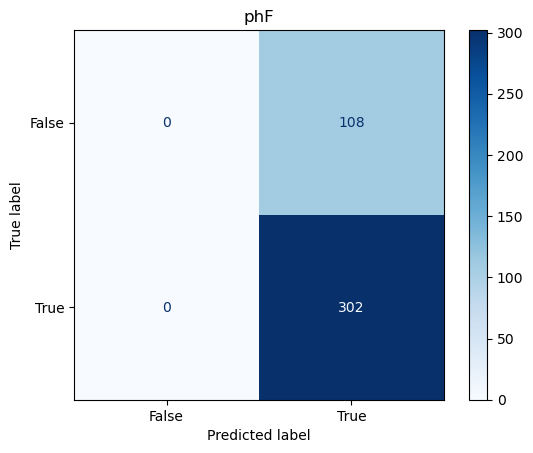

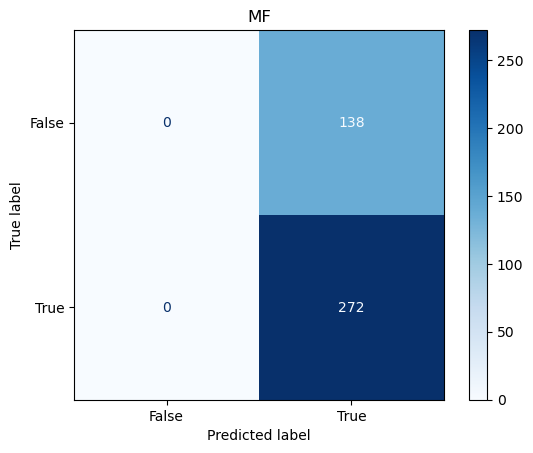

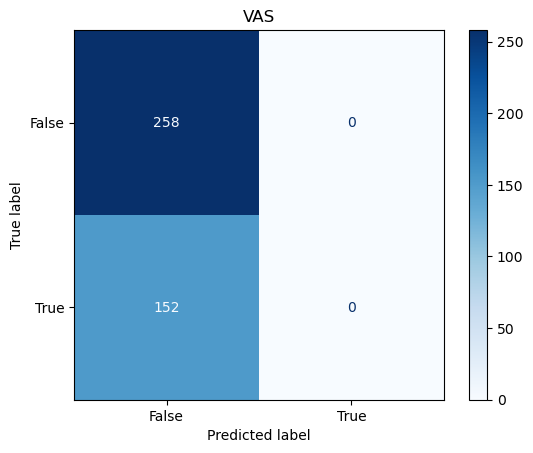

In [8]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import warnings

with warnings.catch_warnings():
    for variable in ('phF', 'MF', 'VAS'):
        print(f'{variable}:\n')

        # ignore numpy warning
        warnings.filterwarnings('ignore')

        # init
        accuracy, f1, recall, precision = [], [], [], []
        train_batches = np.empty((len(subjects), N))
        train_batches[:, :] = np.nan # fill with NaN
        test_batches = []

        # separate folds into batches
        for i, (train_indices, test_indices) in enumerate(LOSOCV_splitter(X)):
            train_size = len(train_indices)
            train_batches[i, :train_size] = X[variable][train_indices]
            test_batches.append(np.array(X[variable][test_indices]))

        # predict
        y_pred = MajorityVoter().predict(train_batches)
        y_true = np.array(test_batches)

        # flatten
        y_pred_flat, y_true_flat = [], []
        for i in range(y_pred.shape[0]):
            y_pred_flat += list(y_pred[i])
            y_true_flat += list(y_true[i])

        # metrics
        accuracy = np.mean([accuracy_score(y_pred=y_pred_batch, y_true=y_true_batch) for (y_pred_batch, y_true_batch) in zip(y_pred, y_true)])
        balanced_accuracy = np.mean([balanced_accuracy_score(y_pred=y_pred_batch, y_true=y_true_batch) for (y_pred_batch, y_true_batch) in zip(y_pred, y_true)])
        f1 = np.mean([f1_score(y_pred=y_pred_batch, y_true=y_true_batch) for (y_pred_batch, y_true_batch) in zip(y_pred, y_true)])
        recall = np.mean([recall_score(y_pred=y_pred_batch, y_true=y_true_batch) for (y_pred_batch, y_true_batch) in zip(y_pred, y_true)])
        precision = np.mean([precision_score(y_pred=y_pred_batch, y_true=y_true_batch) for (y_pred_batch, y_true_batch) in zip(y_pred, y_true)])
        confusion = confusion_matrix(y_pred=y_pred_flat, y_true=y_true_flat)
        metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
        plt.title(variable)

        print(f'accuracy: {accuracy}, balanced accuracy: {balanced_accuracy}, f1: {f1}, recall: {recall}, precision: {precision}\n')